In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ipypb import irange
%matplotlib inline

In [2]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print((major_ver, minor_ver, subminor_ver) )

('4', '1', '1')


In [37]:
# cap = cv2.VideoCapture('bohemian_rhapsody_live_aid.mp4')
# cap = cv2.VideoCapture('240pxqueen.mp4')
cap = cv2.VideoCapture('queen144px.mp4')

In [38]:
total_frames = cap.get(7)

In [39]:
total_frames

5442.0

In [40]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

29.97


In [41]:
total_frames/60

90.7

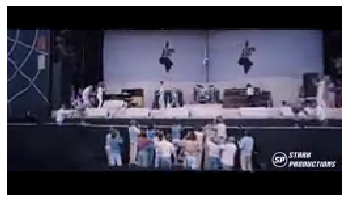

In [195]:
cap.set(1, 600)
ret, frame = cap.read()

RGB_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(RGB_frame)
plt.show()

In [197]:
frame.shape

(144, 256, 3)

In [189]:
def show_2_figs(index1, index2, figsize=20):
    fig = plt.figure(figsize=(figsize, figsize))
    ax1 = fig.add_subplot(2,2,1)
    
    cap.set(1, index2)
    _, frame1 = cap.read()
    cap.set(1, index1)
    _, frame2 = cap.read()
    
    RGB_frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    RGB_past_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(RGB_past_frame)
    ax1.axis('off')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(RGB_frame)
    ax2.axis('off')
    
    plt.show()

# Histogram and Bic Functions
___

In [204]:
import math

def diff_color(img, i, j, m, n):
    return (int(np.linalg.norm(img[i][j] - img[m][n])) > 0)

def calc_global_histogram(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    npixels = lines * cols * channels
    
    max_size = 256
    histogram_red = np.zeros(max_size)
    histogram_green = np.zeros(max_size)
    histogram_blue = np.zeros(max_size)
    
    for i in range(0, lines):
        for j in range(0, cols):
            blue = img[i][j][0]
            red = img[i][j][2]
            green = img[i][j][1]

            histogram_blue[blue] += 1
            histogram_red[red] += 1
            histogram_green[green] += 1
    
    histogram_total = list(histogram_red) + list(histogram_green) + list(histogram_blue)
      
    return np.array(histogram_total) / npixels

def calc_local_histogram(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    max_size = 256
    grid = 5
    npixels = (lines // grid) * (cols // grid) * channels
    
    locals_hist = []
    
    for m in range(0, grid):
        locals_hist.append([])
        for n in range(0, grid):
            locals_hist[m].append([])
            locals_hist[m][n].append(np.zeros(max_size))
            locals_hist[m][n].append(np.zeros(max_size))
            locals_hist[m][n].append(np.zeros(max_size))

    for m in range(0, grid):
        for n in range(0, grid):
            for i in range((lines // grid) * m, (lines // grid) * (m + 1)):
                for j in range((cols // grid) * n, (cols // grid) * (n + 1)):
                    blue = img[i][j][0]
                    red = img[i][j][2]
                    green = img[i][j][1]

                    locals_hist[m][n][0][blue] += 1
                    locals_hist[m][n][1][red] += 1
                    locals_hist[m][n][2][green] += 1
    
    histogram_total = []
    for m in range(0, grid):
        for n in range(0, grid):
            partial = np.array(list(locals_hist[m][n][0]) + list(locals_hist[m][n][1]) + list(locals_hist[m][n][2])) / npixels
            histogram_total += list(partial)
    
    return np.array(histogram_total) / (grid * grid)

def global_histogram(images):
    npixels = images[0].shape[0] * images[0].shape[1]

    hist1 = [x / npixels for x in calc_global_histogram(images[0])]
    hist2 = [x / npixels for x in calc_global_histogram(images[1])]
    
    return np.absolute(array_to_log(hist1) - array_to_log(hist2)).sum() / 2

In [205]:
w = 30

frames_global_hist = {}
frames_local_hist = {}
global_hist_diff = []
local_hist_diff = []

for i in irange(w + 1, int(total_frames), 2 * w + 1):
    past_index = i - 2 * w + 1
    if past_index > 0:
        cap.set(1, i)
        _, frame = cap.read()
        cap.set(1, past_index)
        _, past_frame = cap.read()

        width, height, channels = frame.shape
        npixels = width * height * channels

        if past_index not in frames_global_hist.keys():
            frames_global_hist[past_index] = np.array(calc_global_histogram(past_frame))
        if i not in frames_global_hist.keys():
            frames_global_hist[i] = np.array(calc_global_histogram(frame))

        if past_index not in frames_local_hist.keys():
            frames_local_hist[past_index] = np.array(calc_local_histogram(past_frame)) 
        if i not in frames_local_hist.keys():
            frames_local_hist[i] = np.array(calc_local_histogram(frame))

        diff_global_hist =  np.absolute(frames_global_hist[past_index] - frames_global_hist[i]).sum() / 2
        diff_local_hist =  np.absolute(frames_local_hist[past_index] - frames_local_hist[i]).sum() / 2

        global_hist_diff.append({
            "diff": diff_global_hist,
            "past_index": past_index,
            "actual_index": i,
        })

        local_hist_diff.append({
            "diff": diff_local_hist,
            "past_index": past_index,
            "actual_index": i,
        })


 [████████████████████████████████████████████████████████████] 89/89 [00:31<00:00, 0.34s/it]

# Global histogram
___

In [206]:
np.array([x['diff'] for x in global_hist_diff])

array([0.71335178, 0.16111473, 0.09400318, 0.20954499, 0.17670356,
       0.33837891, 0.14709925, 0.13326461, 0.11856192, 0.15852865,
       0.23511646, 0.14924226, 0.18995949, 0.14670139, 0.17306858,
       0.13236039, 0.16834852, 0.10252098, 0.15266927, 0.10576714,
       0.2818287 , 0.29462348, 0.26786748, 0.12455693, 0.14237015,
       0.12868019, 0.13154659, 0.08260091, 0.05277054, 0.06044741,
       0.05654116, 0.06342231, 0.27548105, 0.26073315, 0.28825774,
       0.04872866, 0.25446687, 0.24130136, 0.18211082, 0.24042426,
       0.2134422 , 0.28727214, 0.15165654, 0.07644314, 0.06514938,
       0.27317527, 0.05759006, 0.04692021, 0.28123192, 0.28217231,
       0.07228371, 0.39886249, 0.23346173, 0.44745551, 0.19412797,
       0.1636556 , 0.38767723, 0.07568359, 0.22659867, 0.17211914,
       0.10053168, 0.42716471, 0.18379268, 0.13696289, 0.15877279,
       0.30026584, 0.04168475, 0.42336697, 0.38943142, 0.22370515,
       0.22486256, 0.19697627, 0.40828451, 0.22775608, 0.22288

In [207]:
np.array([x['diff'] for x in global_hist_diff]).mean()

0.21079970851089014

In [208]:
result = []

for element in global_hist_diff:
    if element["diff"] > 0.2:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

42


# Local histogram grid 5x5
___

In [187]:
np.array([x['diff'] for x in local_hist_diff])

array([0.77794585, 0.37254902, 0.35985994, 0.44359477, 0.33276377,
       0.44929972, 0.35923436, 0.35697479, 0.39718954, 0.38671335,
       0.45514472, 0.45910364, 0.5007563 , 0.37427638, 0.38434174,
       0.4080859 , 0.41721755, 0.3142577 , 0.37952381, 0.34210084,
       0.53553688, 0.5914099 , 0.58633987, 0.36854342, 0.4026704 ,
       0.39540616, 0.37281979, 0.27671335, 0.21132586, 0.22590103,
       0.20564893, 0.21686275, 0.51039216, 0.58383754, 0.51272642,
       0.18335201, 0.52785247, 0.52822596, 0.48142857, 0.51938375,
       0.5007563 , 0.52588235, 0.42553688, 0.25275444, 0.21399627,
       0.527507  , 0.19777778, 0.18101774, 0.58014939, 0.57655462,
       0.21087768, 0.60102708, 0.43138189, 0.57997199, 0.50049486,
       0.48437908, 0.63279178, 0.21373483, 0.46792717, 0.41067227,
       0.31647059, 0.58962652, 0.48034547, 0.35716153, 0.40085901,
       0.51392157, 0.14041083, 0.63935574, 0.63070962, 0.52034547,
       0.62060691, 0.50671335, 0.59959851, 0.50851541, 0.55559

In [191]:
np.array([x['diff'] for x in local_hist_diff]).mean()

0.4463653340123928

In [198]:
result = []

for element in local_hist_diff:
    if element["diff"] > 0.5:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

39
